In [1]:
cd ..

/Users/huttercl/Documents/StrokeRecovery/CorrelationGraph4Stroke_public


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from StrokeRecovery import utils, preprocessing
from StrokeRecovery import interactionmodel as IM
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import signal 
from StrokeRecovery.graph_viz import GraphViz

version = 'v1.6'
window = 'blackman'
n_edges = 6

In [3]:
patients = pd.read_excel('data/ds2a_patients_{}.xlsx'.format(version), index_col=[0])
limos = pd.read_excel('data/ds2b_limos_{}.xlsx'.format(version), index_col=[0,1])

# Timeseries

In [4]:
builder = preprocessing.LimosSequenceBuilder(limos)
normalized_sequences = builder.normalized_delta_sequences

In [5]:
graph_table = IM.estimate(normalized_sequences, padding_factor=1000, norm='l1', window_name=window)

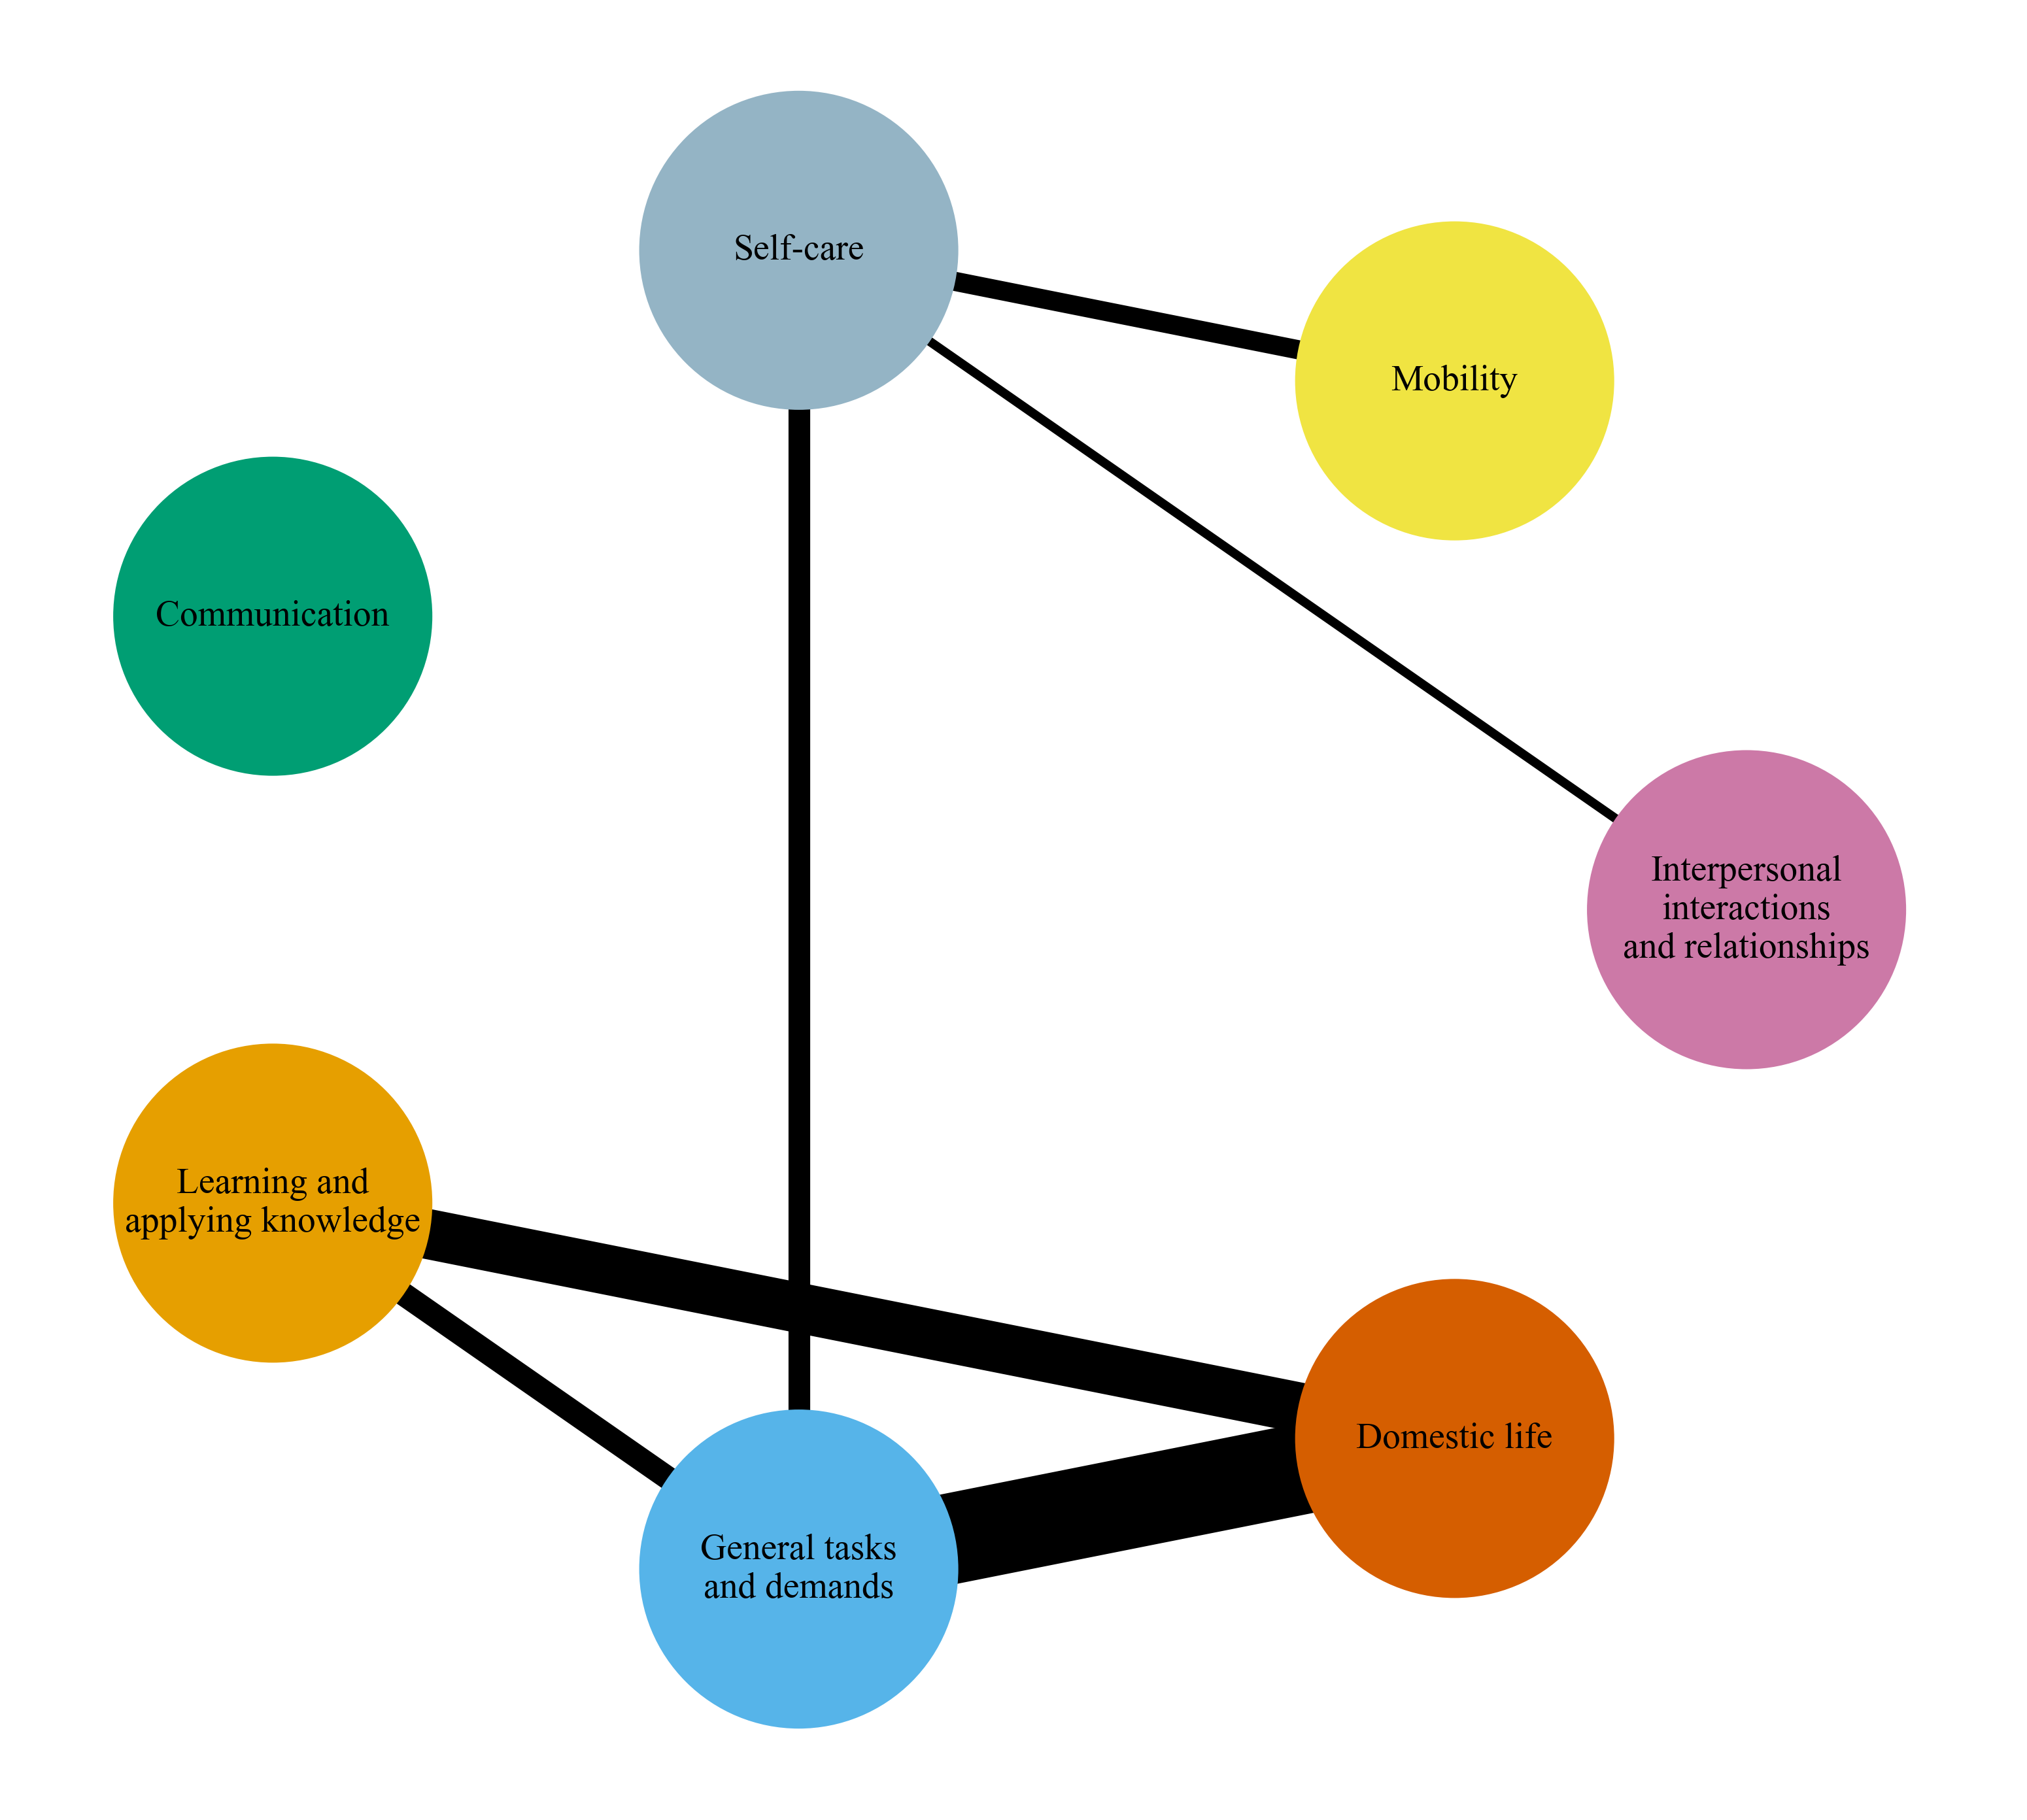

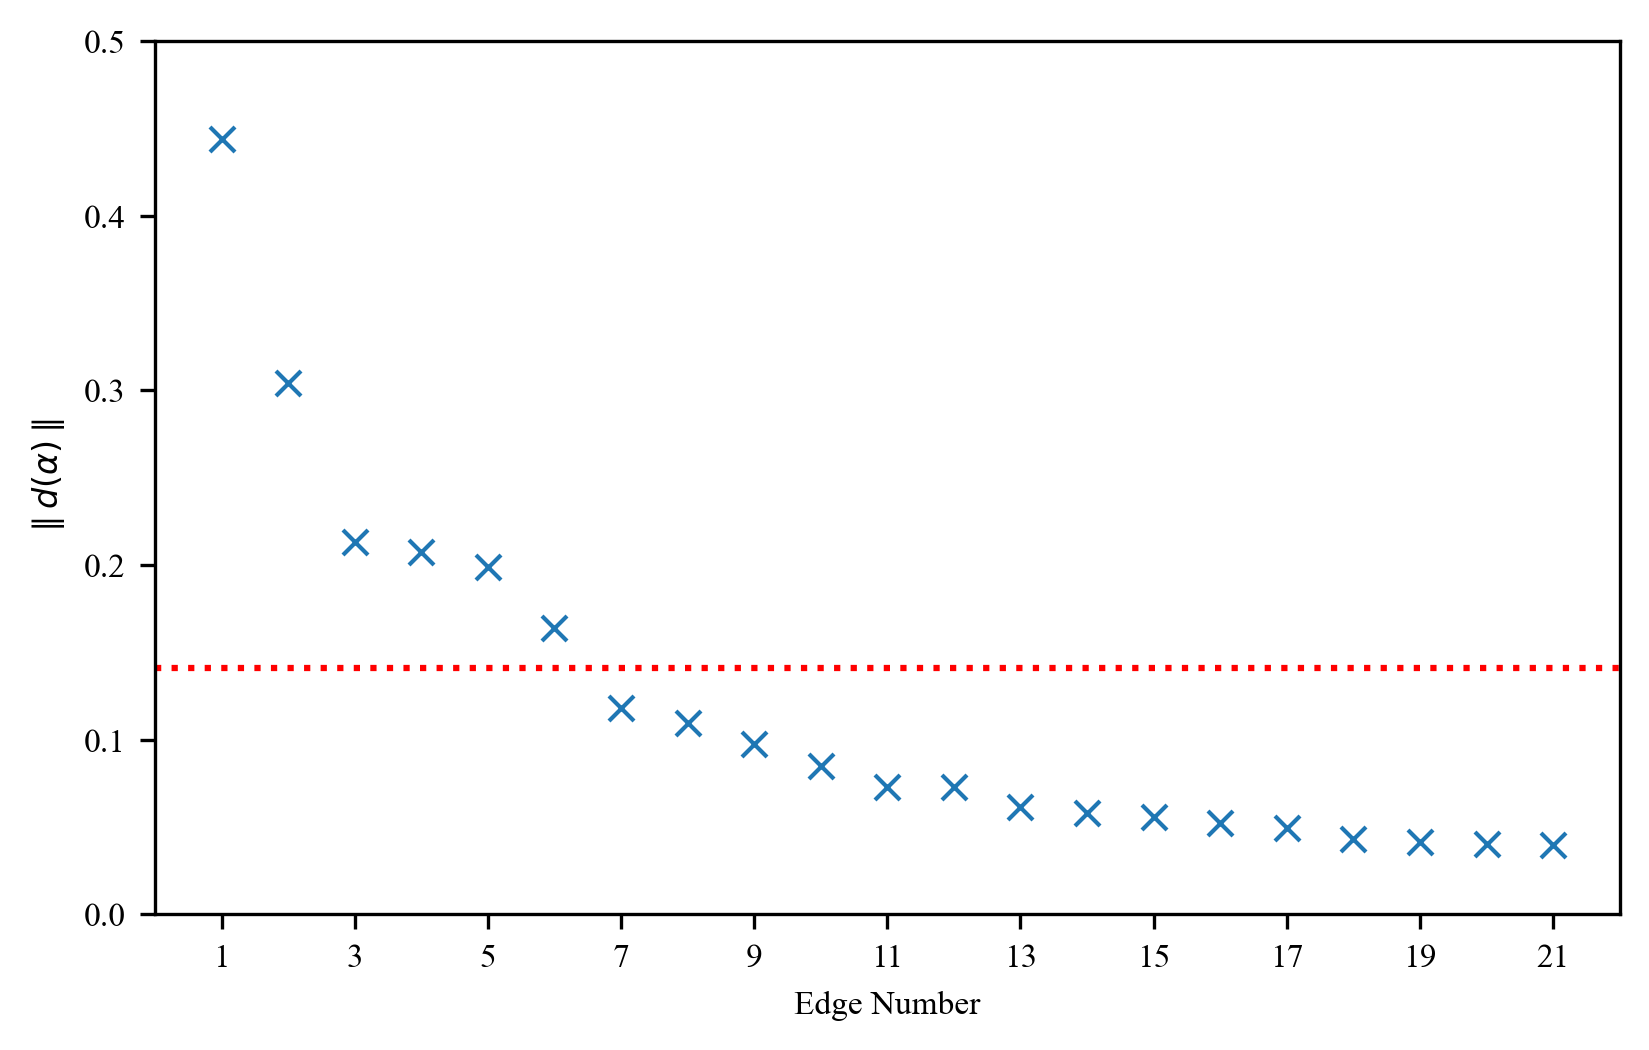

In [6]:
main_graph = GraphViz(graph_table, builder.columns)

graph_fig = main_graph.show_graph(n_edges)
knee_fig  = main_graph.knee_plot(n_edges)
graph_fig.get_figure().savefig('figs/timeseries_graph.pdf')
knee_fig.get_figure().savefig('figs/timeseries_graph_knee.pdf')

## Bootstrap

In [7]:
main_edges = main_graph.top_edges(n_edges)

In [8]:
all_possible_edges = main_graph.top_edges(0.0)
assert len(all_possible_edges) == 21

In [9]:
n_resampling = 10000
collector = list()
extra_edges_col = list()
missing_edges_col = list()

for n in range(n_resampling):
    other_gv = GraphViz(IM.estimate(normalized_sequences, padding_factor=100, subsample_data=1, bootstrap=True, norm='l1', window_name=window), builder.columns)
    
    other_edges = other_gv.top_edges(n_edges)
    
    extra_edges = (other_edges-main_edges)
    missing_edges = (main_edges-other_edges)
    
    dif1 = len(extra_edges)
    dif2 = len(missing_edges) 
    
    assert dif1==dif2
    collector.append(dif1)
    
    extra_edges_col.extend(extra_edges)
    missing_edges_col.extend(missing_edges)
    

(array([0, 1, 2]), array([7184, 2792,   24]))


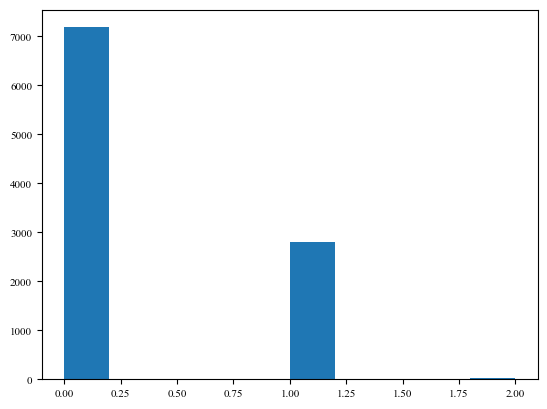

In [10]:
print(np.unique(collector, return_counts=True))
_=plt.hist(collector)

In [11]:
extra_edge_series = pd.Series(extra_edges_col).value_counts()

In [12]:
missing_edge_series = pd.Series(missing_edges_col).value_counts()

In [13]:
# add missing/extra edges that occured with frequency 0
main_edges_that_were_never_missing = main_edges - set(missing_edge_series.keys()) 
extra_edges_that_never_occured = (all_possible_edges - main_edges) - set(extra_edge_series.keys())

all_missing_edges = pd.concat([missing_edge_series , pd.Series(index = list(main_edges_that_were_never_missing), data=0)])
all_extra_edges = pd.concat([extra_edge_series, pd.Series(index=list(extra_edges_that_never_occured), data=0)])

include_zero_counts = True
if include_zero_counts:
    extra_edges4table = all_extra_edges
    missing_edges4table = all_missing_edges
else:
    extra_edges4table = extra_edge_series
    missing_edges4table = missing_edge_series

#### Save to excel and make latex table

In [14]:
missing_edges_name = 'Missing edges (\%)'
extra_edges_name = 'Extra edges (\%)'

In [15]:
diff_edges = pd.DataFrame(data={ missing_edges_name : missing_edges4table, extra_edges_name:extra_edges4table}).sort_values(by=[missing_edges_name, extra_edges_name], ascending=False)
in_percent = ((diff_edges/n_resampling)*100)
formated2 = in_percent.style.format(formatter="{:.2f}", na_rep='-')
formated2.to_excel('figs/missing_and_extra_edges.xlsx')

In [16]:
in_percent

,Missing edges (\%),Extra edges (\%)
InterpersInteraction-Selfcare,24.21,NaN
Generaltasks-LearningKnowledge,1.98,NaN
Mobility-Selfcare,1.19,NaN
Generaltasks-Selfcare,1.02,NaN
DomesticLife-Generaltasks,0.00,NaN
DomesticLife-LearningKnowledge,0.00,NaN
DomesticLife-Mobility,NaN,15.18
Communication-Selfcare,NaN,6.40
Communication-InterpersInteraction,NaN,3.52
Communication-LearningKnowledge,NaN,1.78


In [17]:
import jinja2
latex_jinja_env = jinja2.Environment(
    variable_start_string = "\VAR{",
    variable_end_string = "}",
)
multiline_template = latex_jinja_env.from_string(r"""\multicolumn{1}{l|}{\VAR{firstNode}\dotfill} & \multirow{2}{*}{\VAR{missingPercent}} & \multirow{2}{*}{\VAR{extraPercent}} \\
\multicolumn{1}{r|}{\dotfill{}\VAR{secondNode}}& &\\""")

singleline_template = latex_jinja_env.from_string(r"{\VAR{firstNode}\dotfill{}\VAR{secondNode}} & \VAR{missingPercent} & \VAR{extraPercent}  \\")


In [18]:
def map_row(edge_name, data):
    linebreakthreshold = 40 
    
    first, second = edge_name.split('-')
    rfirst = utils.get_category_rename_dict()[first]
    rsecond = utils.get_category_rename_dict()[second]
    
    missing = data[missing_edges_name]
    extra = data[extra_edges_name]
    
    nanToEmpty = lambda val: "" if pd.isnull(val) else "{:.2f}".format(val)
    
    if len(rfirst) + len(rsecond) > linebreakthreshold:
        template = multiline_template
    else:
        template = singleline_template
    
    new = template.render(firstNode=rfirst, secondNode=rsecond, missingPercent = nanToEmpty(missing), extraPercent = nanToEmpty(extra))
    return new

lines_collector = list()
for name, data in in_percent.iterrows():
    lines_collector.append(map_row(name, data))
    
    
print("LaTeX: \n\n")
print("\n\\hline\n".join(lines_collector))

LaTeX: 


\multicolumn{1}{l|}{Interpersonal interactions and relationships\dotfill} & \multirow{2}{*}{24.21} & \multirow{2}{*}{} \\
\multicolumn{1}{r|}{\dotfill{}Self-care}& &\\
\hline
\multicolumn{1}{l|}{General tasks and demands\dotfill} & \multirow{2}{*}{1.98} & \multirow{2}{*}{} \\
\multicolumn{1}{r|}{\dotfill{}Learning and applying knowledge}& &\\
\hline
{Mobility\dotfill{}Self-care} & 1.19 &   \\
\hline
{General tasks and demands\dotfill{}Self-care} & 1.02 &   \\
\hline
{Domestic life\dotfill{}General tasks and demands} & 0.00 &   \\
\hline
\multicolumn{1}{l|}{Domestic life\dotfill} & \multirow{2}{*}{0.00} & \multirow{2}{*}{} \\
\multicolumn{1}{r|}{\dotfill{}Learning and applying knowledge}& &\\
\hline
{Domestic life\dotfill{}Mobility} &  & 15.18  \\
\hline
{Communication\dotfill{}Self-care} &  & 6.40  \\
\hline
\multicolumn{1}{l|}{Communication\dotfill} & \multirow{2}{*}{} & \multirow{2}{*}{3.52} \\
\multicolumn{1}{r|}{\dotfill{}Interpersonal interactions and relationships}& &\\